In [1]:
# import system libs
import os
import itertools

# import data handling tools
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import EfficientNetB3

# ignore the warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# loading the dataset
def loading_the_data(data_dir):
    # Generate data paths with labels
    filepaths = []
    labels = []

    # Get folder names
    folds = os.listdir(data_dir)

    for fold in folds:
        foldpath = os.path.join(data_dir, fold)
        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)

            filepaths.append(fpath)
            labels.append(fold)

    # Concatenate data paths with labels into one DataFrame
    Fseries = pd.Series(filepaths, name='filepaths')
    Lseries = pd.Series(labels, name='labels')

    df = pd.concat([Fseries, Lseries], axis=1)

    return df


# change label names to its original names
def change_label_names(df, column_name):
    index = {'blast': 'Blast', 'rust': 'Rust'}


    df[column_name] = df[column_name].replace(index)

In [3]:
# loading the data
data_dir = r"C:\Users\91912\Desktop\robotics_data\dataset"
df = loading_the_data(data_dir)

change_label_names(df, 'labels')

df

filepaths labels
0     C:\Users\91912\Desktop\robotics_data\dataset\b...  Blast
1     C:\Users\91912\Desktop\robotics_data\dataset\b...  Blast
2     C:\Users\91912\Desktop\robotics_data\dataset\b...  Blast
3     C:\Users\91912\Desktop\robotics_data\dataset\b...  Blast
4     C:\Users\91912\Desktop\robotics_data\dataset\b...  Blast
...                                                 ...    ...
4962  C:\Users\91912\Desktop\robotics_data\dataset\r...   Rust
4963  C:\Users\91912\Desktop\robotics_data\dataset\r...   Rust
4964  C:\Users\91912\Desktop\robotics_data\dataset\r...   Rust
4965  C:\Users\91912\Desktop\robotics_data\dataset\r...   Rust
4966  C:\Users\91912\Desktop\robotics_data\dataset\r...   Rust

[4967 rows x 2 columns]

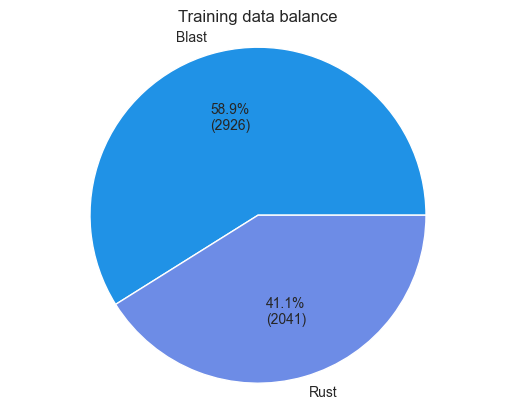

In [4]:
data_balance = df.labels.value_counts()


def custom_autopct(pct):
    total = sum(data_balance)
    val = int(round(pct*total/100.0))
    return "{:.1f}%\n({:d})".format(pct, val)


# pie chart for data balance
plt.pie(data_balance, labels = data_balance.index, autopct=custom_autopct, colors = ["#2092E6","#6D8CE6","#20D0E6"])
plt.title("Training data balance")
plt.axis("equal")
plt.show()

In [5]:
# data --> 80% train data && 20% (test, val)
train_df, ts_df = train_test_split(df, train_size = 0.8, shuffle = True, random_state = 42)

# test data --> 10% train data && 10% (test, val)
valid_df, test_df = train_test_split(ts_df, train_size = 0.5, shuffle = True, random_state = 42)

In [6]:
# crobed image size
batch_size = 32
img_size = (224, 224)

tr_gen = ImageDataGenerator(rescale=1. / 255)
ts_gen = ImageDataGenerator(rescale=1. / 255)

train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)

Found 3973 validated image filenames belonging to 2 classes.
Found 497 validated image filenames belonging to 2 classes.
Found 497 validated image filenames belonging to 2 classes.


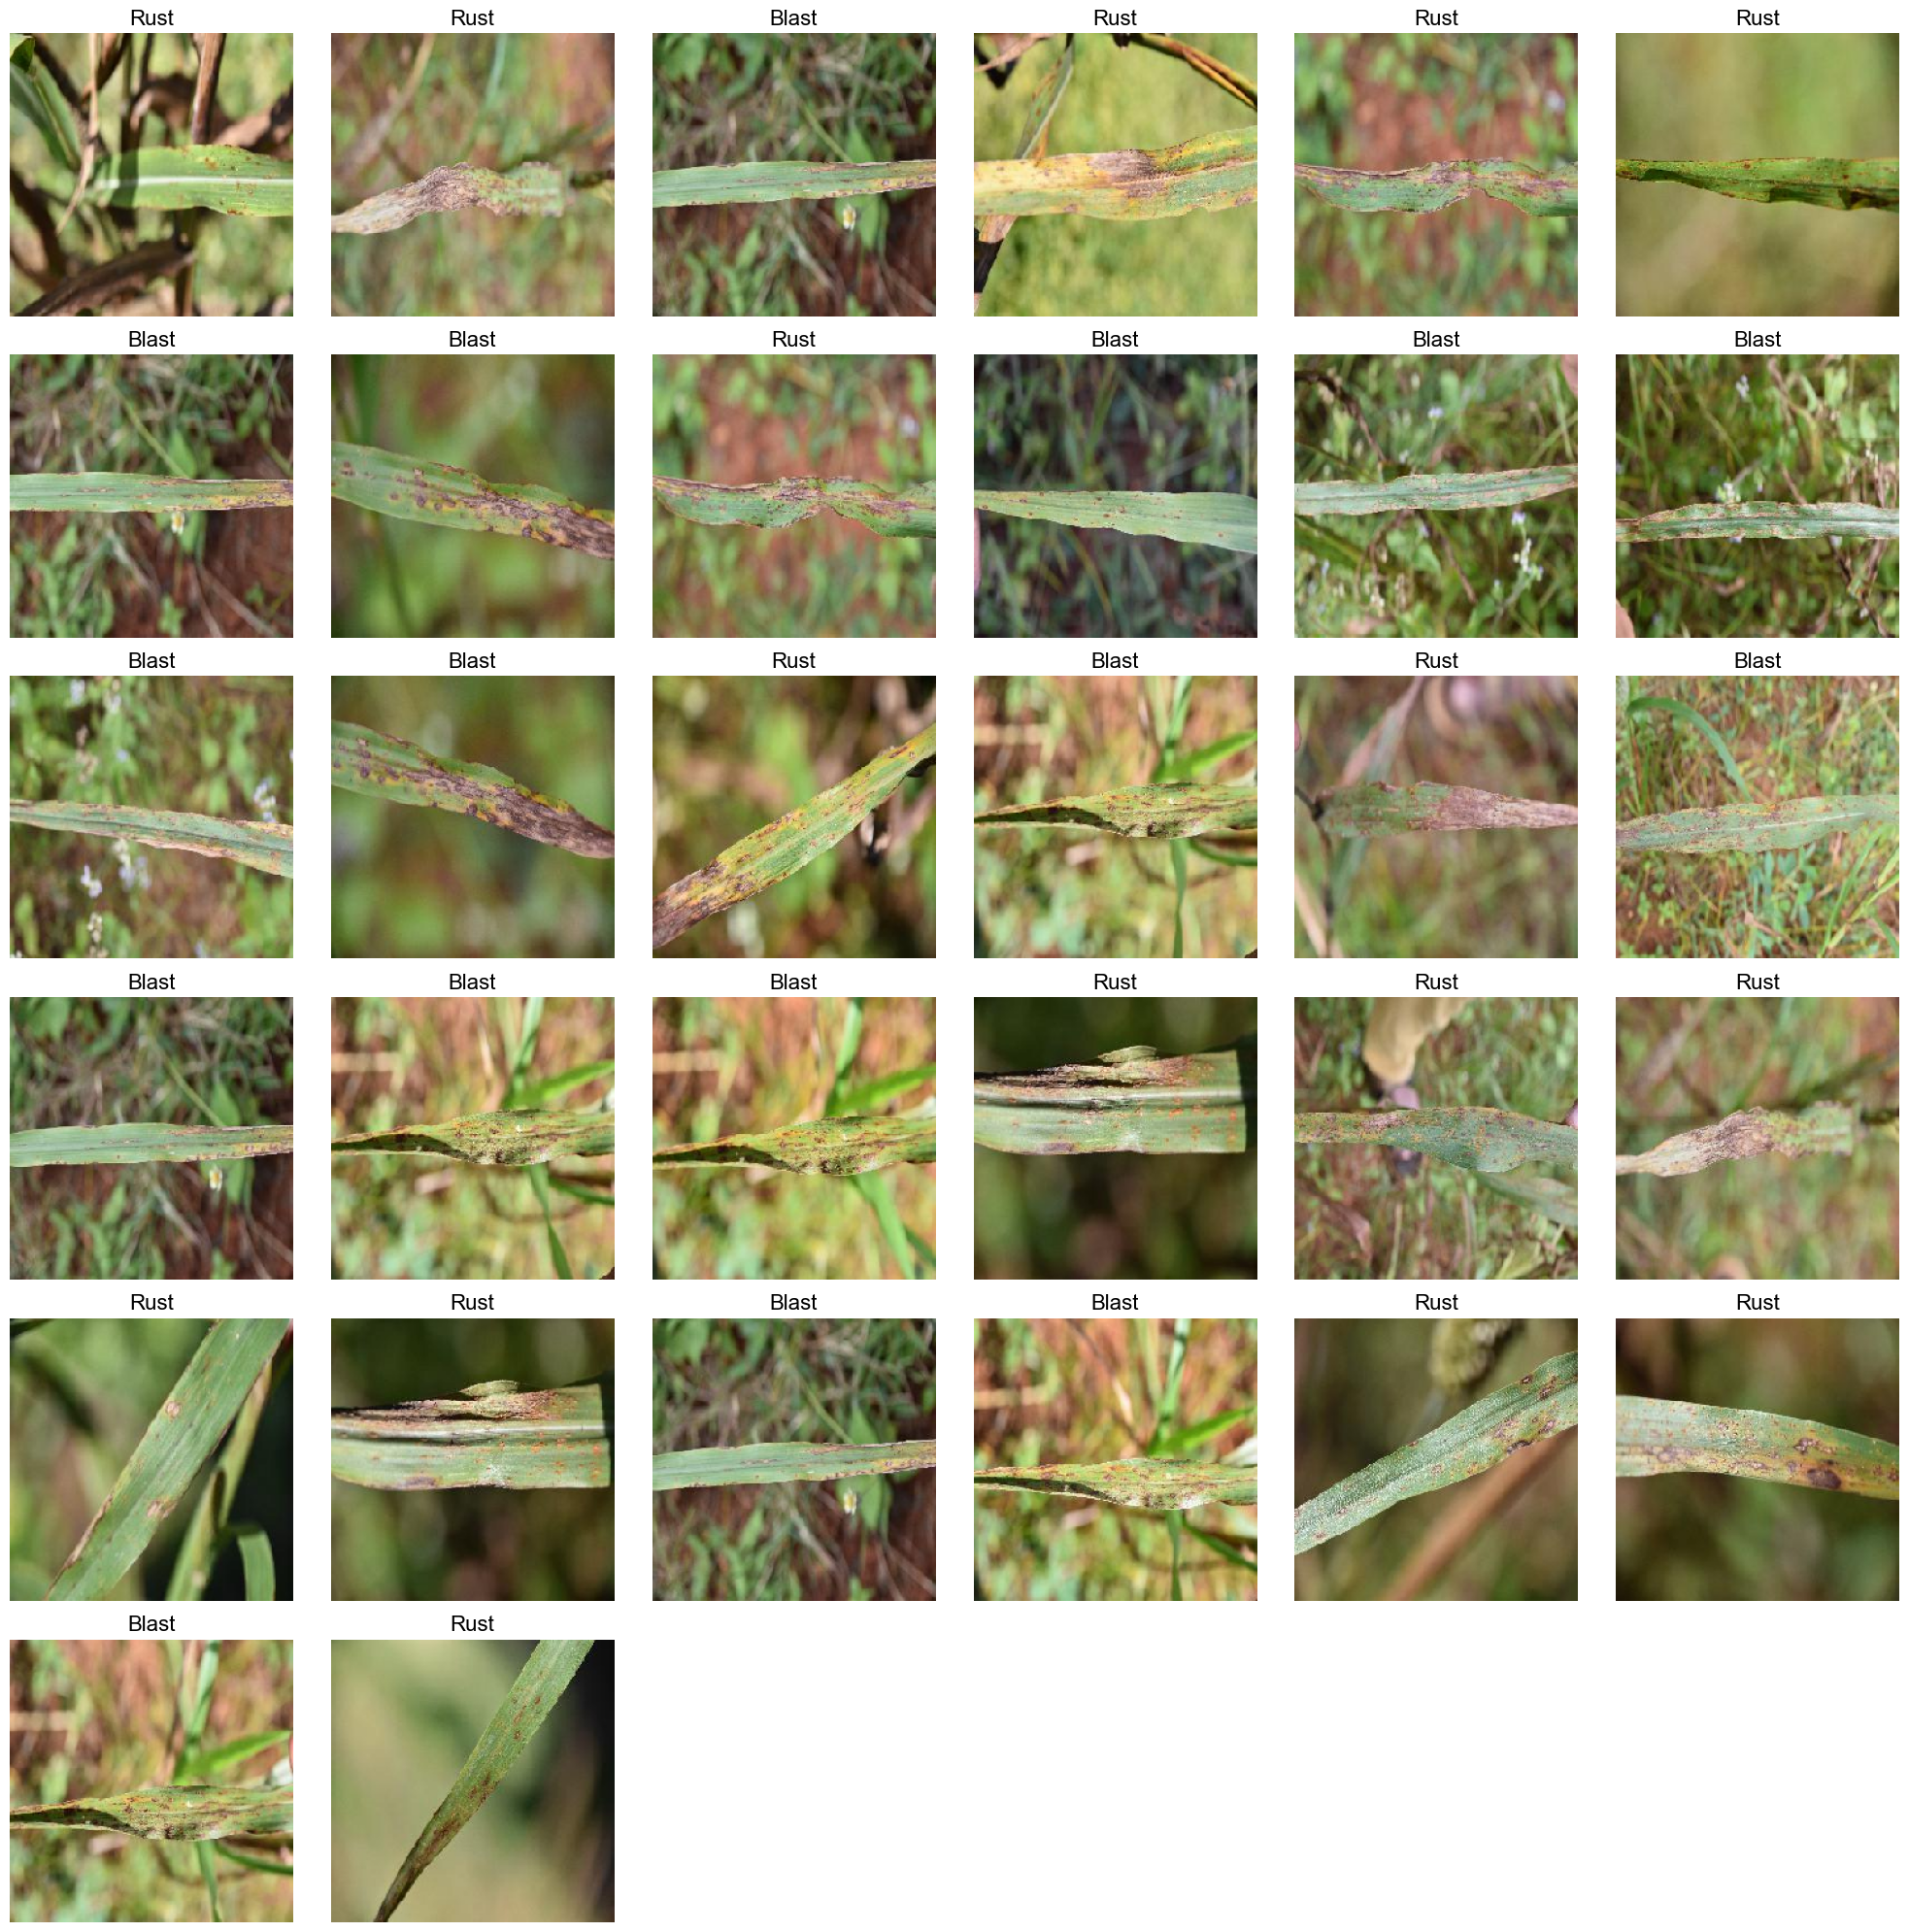

In [7]:
g_dict = train_gen.class_indices      # defines dictionary {'class': index}
classes = list(g_dict.keys())       # defines list of dictionary's kays (classes), classes names : string
images, labels = next(train_gen)      # get a batch size samples from the generator

# ploting the patch size samples
plt.figure(figsize= (20, 20))

for i in range(batch_size):
    plt.subplot(6, 6, i + 1)
    image = images[i]
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]   # get class of image
    plt.title(class_name, color= 'black', fontsize= 16)
    plt.axis('off')
plt.tight_layout()
plt.show()

In [8]:
# Displaying the model performance
def model_performance(history, Epochs):
    # Define needed variables
    tr_acc = history.history['accuracy']
    tr_loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']

    Epochs = [i+1 for i in range(len(tr_acc))]

    # Plot training history
    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')

    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout
    plt.show()


# Evaluate the model
def model_evaluation(model):
    train_score = model.evaluate(train_gen, verbose= 1)
    valid_score = model.evaluate(valid_gen, verbose= 1)
    test_score = model.evaluate(test_gen, verbose= 1)

    print("Train Loss: ", train_score[0])
    print("Train Accuracy: ", train_score[1])
    print('-' * 20)
    print("Validation Loss: ", valid_score[0])
    print("Validation Accuracy: ", valid_score[1])
    print('-' * 20)
    print("Test Loss: ", test_score[0])
    print("Test Accuracy: ", test_score[1])


# Get Predictions
def get_pred(model, test_gen):

    preds = model.predict(test_gen)
    y_pred = np.argmax(preds, axis = 1)

    return y_pred


# Confusion Matrix
def plot_confusion_matrix(test_gen, y_pred):

    g_dict = test_gen.class_indices
    classes = list(g_dict.keys())

    # Display the confusion matrix
    cm = confusion_matrix(test_gen.classes, y_pred)

    plt.figure(figsize= (10, 10))
    plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation= 45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')


    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

    plt.show()


# Defining a convolutional NN block for a sequential CNN model
def conv_block(filters, act='relu'):

    block = Sequential()
    block.add(Conv2D(filters, 3, activation=act, padding='same'))
    block.add(Conv2D(filters, 3, activation=act, padding='same'))
    block.add(BatchNormalization())
    block.add(MaxPooling2D())

    return block


# Defining a dense NN block for a sequential CNN model
def dense_block(units, dropout_rate, act='relu'):

    block = Sequential()
    block.add(Dense(units, activation=act))
    block.add(BatchNormalization())
    block.add(Dropout(dropout_rate))

    return block

In [9]:
# create Model structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

class_counts = len(list(train_gen.class_indices.keys()))     # to define number of classes in dense layer

In [10]:
# Model architecture
cnn_model = Sequential()

# first conv block
cnn_model.add(Conv2D(filters=16, kernel_size=(3,3), padding="same", activation="relu", input_shape= img_shape))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling2D())

# second conv block
cnn_model.add(conv_block(32))

# third conv block
cnn_model.add(conv_block(64))

# fourth conv bolck
cnn_model.add(conv_block(128))

# fifth conv block
cnn_model.add(conv_block(256))

# flatten layer
cnn_model.add(Flatten())

# first dense block
cnn_model.add(dense_block(128, 0.5))

# second dense block
cnn_model.add(dense_block(64, 0.3))

# third dense block
cnn_model.add(dense_block(32, 0.2))

# output layer
cnn_model.add(Dense(class_counts, activation = "softmax"))

In [11]:
cnn_model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

cnn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 56, 56, 32)     │        14,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_2 (Sequential)       │ (None, 28, 28, 64)     │        55,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_3 (Sequential)       │ (None, 14, 14, 128)    │       221,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_4 (Sequential)       │ (None, 7, 7, 256)      │       886,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_5 (Sequential)       │ (None, 128)            │     1,606,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_6 (Sequential)       │ (None, 64)             │         8,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_7 (Sequential)       │ (None, 32)             │         2,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,795,490 (10.66 MB)

 Trainable params: 2,794,050 (10.66 MB)

 Non-trainable params: 1,440 (5.62 KB)

In [12]:
# train the model
epochs = 35   # number of all epochs in training

history = cnn_model.fit(train_gen, epochs= epochs, verbose= 1, validation_data= valid_gen, shuffle= False)

Epoch 1/35
125/125 ━━━━━━━━━━━━━━━━━━━━ 125s 964ms/step - accuracy: 0.7469 - loss: 0.5862 - val_accuracy: 0.4125 - val_loss: 2.9538
Epoch 2/35
125/125 ━━━━━━━━━━━━━━━━━━━━ 115s 921ms/step - accuracy: 0.8866 - loss: 0.2946 - val_accuracy: 0.4125 - val_loss: 2.5792
Epoch 3/35
125/125 ━━━━━━━━━━━━━━━━━━━━ 121s 965ms/step - accuracy: 0.9467 - loss: 0.1462 - val_accuracy: 0.4668 - val_loss: 2.1465
Epoch 4/35
125/125 ━━━━━━━━━━━━━━━━━━━━ 120s 956ms/step - accuracy: 0.9705 - loss: 0.0926 - val_accuracy: 0.5231 - val_loss: 3.6471
Epoch 5/35
125/125 ━━━━━━━━━━━━━━━━━━━━ 134s 1s/step - accuracy: 0.9663 - loss: 0.0896 - val_accuracy: 0.6740 - val_loss: 0.8517
Epoch 6/35
125/125 ━━━━━━━━━━━━━━━━━━━━ 134s 1s/step - accuracy: 0.9828 - loss: 0.0634 - val_accuracy: 0.9899 - val_loss: 0.0475
Epoch 7/35
125/125 ━━━━━━━━━━━━━━━━━━━━ 129s 1s/step - accuracy: 0.9850 - loss: 0.0466 - val_accuracy: 0.9920 - val_loss: 0.0326
Epoch 8/35
125/125 ━━━━━━━━━━━━━━━━━━━━ 129s 1s/step - accuracy: 0.9800 - loss: 0.056

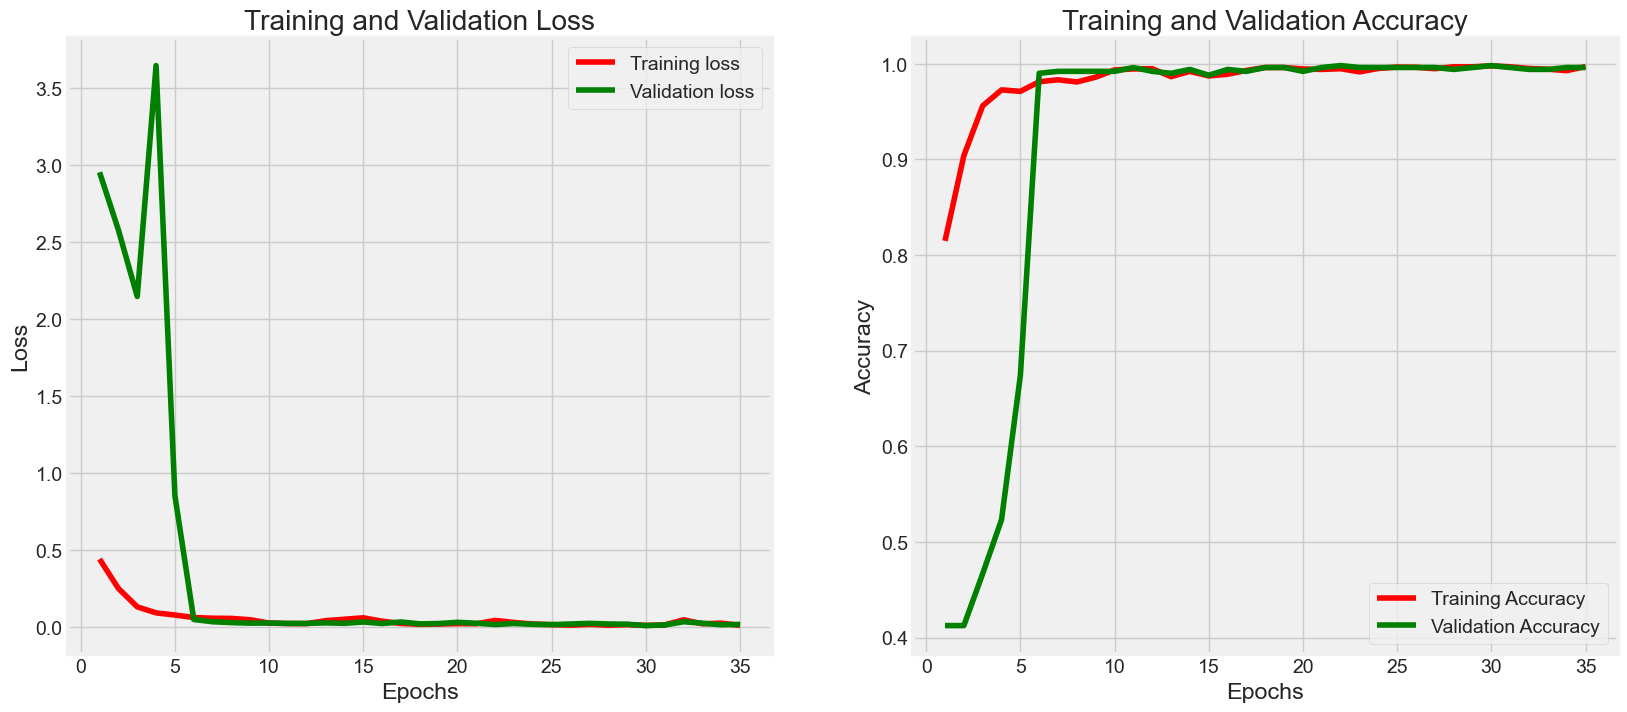

In [13]:
# Display model performance
model_performance(history, epochs)

In [14]:
# Model evaluation
model_evaluation(cnn_model)

125/125 ━━━━━━━━━━━━━━━━━━━━ 23s 184ms/step - accuracy: 1.0000 - loss: 2.1106e-04
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 194ms/step - accuracy: 0.9967 - loss: 0.0209
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 197ms/step - accuracy: 0.9979 - loss: 0.0042
Train Loss:  0.00021806915174238384
Train Accuracy:  1.0
--------------------
Validation Loss:  0.015527414157986641
Validation Accuracy:  0.9959758520126343
--------------------
Test Loss:  0.003690051846206188
Test Accuracy:  0.9979879260063171


In [15]:
cnn_model.save("Blast_Rust_Model.h5")

ValueError: Unable to synchronously create dataset (name already exists)

In [16]:
cnn_model.save("Blast_Rust_Model.keras")

16/16 ━━━━━━━━━━━━━━━━━━━━ 57s 3s/step


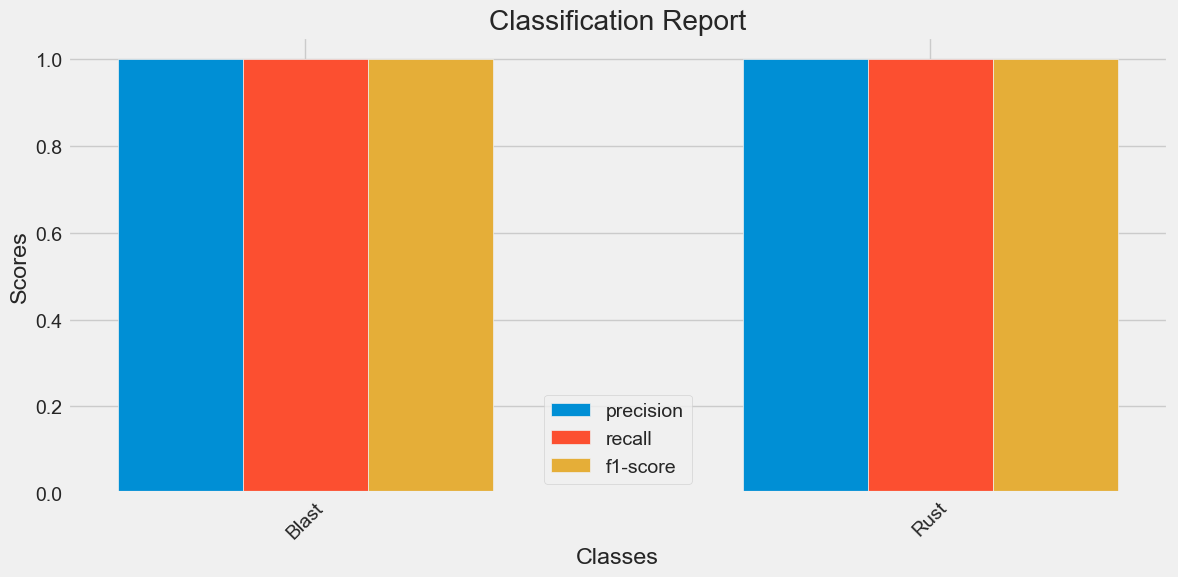

In [36]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder

Y_pred = EfficientNetB3_model.predict(test_gen)
y_pred = np.argmax(Y_pred, axis=1)

# Convert class labels from one-hot encoding to original labels
encoder = LabelEncoder()
true_labels = encoder.fit_transform(test_gen.classes)
predicted_labels = y_pred

# Generate classification report
report = classification_report(true_labels, predicted_labels, target_names=test_gen.class_indices.keys(), output_dict=True)

# Extract metrics for each class
classes = list(report.keys())[:-3]  # Exclude 'accuracy', 'macro avg', and 'weighted avg'
metrics = ['precision', 'recall', 'f1-score']
scores = np.zeros((len(classes), len(metrics)))

for i, class_ in enumerate(classes):
    for j, metric in enumerate(metrics):
        scores[i, j] = report[class_][metric]

# Plotting the classification report as a bar chart
plt.figure(figsize=(12, 6))
bar_width = 0.2
index = np.arange(len(classes))

for i, metric in enumerate(metrics):
    plt.bar(index + i * bar_width, scores[:, i], bar_width, label=metric)

plt.xlabel('Classes')
plt.ylabel('Scores')
plt.title('Classification Report')
plt.xticks(index + bar_width, classes, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


In [37]:
from sklearn.metrics import classification_report

Y_pred = cnn_model.predict(test_gen)  # Assuming EfficientNetB3_model is your trained model
y_pred = np.argmax(Y_pred, axis=1)

print(classification_report(test_gen.classes, y_pred))


16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 168ms/step
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       305
           1       1.00      0.99      0.99       194

    accuracy                           1.00       499
   macro avg       1.00      0.99      1.00       499
weighted avg       1.00      1.00      1.00       499


16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 171ms/step


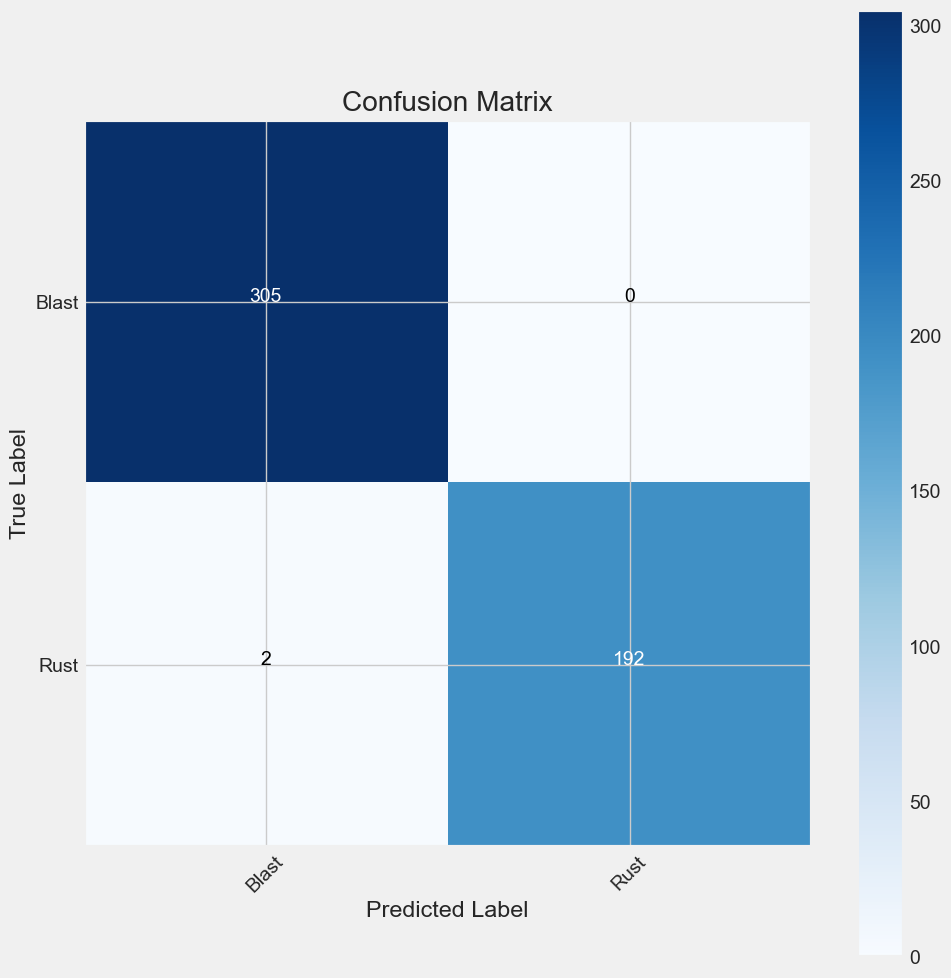

In [32]:
# get predictions
y_pred = get_pred(cnn_model, test_gen)

# plot the confusion matrix
plot_confusion_matrix(test_gen, y_pred)